In [5]:
from matplotlib import pyplot as plt
import json

In [44]:
G = 2
name = 'checkpoints/ppo/transfer{}.res'.format(G)
name_full = 'checkpoints/ppo/transfer{}_full.res'.format(G)

with open(name) as f:
    data = json.load(f)
with open(name_full) as f:
    data_full = json.load(f)

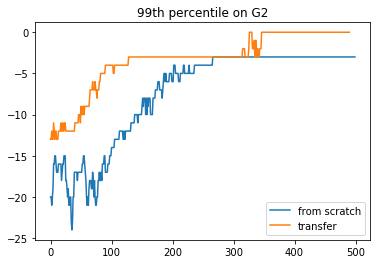

In [45]:
lim = 500

plt.plot(data_full['train_percentiles'][:lim], label='from scratch')
plt.plot(data['train_percentiles'][:lim], label='transfer')
plt.title('99th percentile on G{}'.format(G))
plt.legend(loc=4)
plt.show()